In [1]:
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [1]:
from fastbook import *

# Collaborative Filtering

## The Data

This example uses a dataset called [MovieLens](https://grouplens.org/datasets/movielens/). It contains millions of movie rankings. We will use a subset of 100,000 here. The data is available through a fastai function.

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

The main table is tab-separated and the columns represent user, movie, rating, and timestamp. We assign the headers since they are not included in the file.

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Creating the DataLoaders

The table `u.item` contains the mapping of IDs to titles:

In [4]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


The ratings table contains the data we need to model. We can build a `DataLoaders` object from it. By default, dataloaders takes the first column for the user, the second column for the item (here the movies), and the third column for the ratings. The 'item_name' option overrides this default.

In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


With N factors, we need a matrix of N x N_Users for the users' latent factors, and a matrix of N_Movies for the movies' latent factors:

In [7]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

The result or score for a single user/movie combination is the dot product of the user's latent factors and the movie's latent factors. Mentally this is easy to conceptualise, and in something like Excel you might use lookups to select a user and a movie and perform the dot product multiplication, but that mechanism doesn't really transfer to deep learning frameworks. Deep learning models are based on matrix products and activation functions, not lookups. 

There is a trick to represent 'lookups' as a matrix product. We replace our indices with one-hot-encoded vectors. Here's an example for index 3:

In [8]:
one_hot_3 = one_hot(3, n_users).float()

In [9]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

If we index directly into the matrix, we get the same vector.

In [10]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

So one-hot-encoding a matrix and multiplying it by the matrix of latent factors is the same as doing a lookup directly.

This works, but will use a lot of memory and time. PyTorch has a special layer that indexes into a vector using an integer, but has its derivative calculated in such a way that it's identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is an embedding.

For some problems (like image recognition) the number of latent factors might seem obvious - for example images are represented in RGB form by three numbers.
For something like movie recommendations, how many factors are relevant? We don't instruct the model on this, we let it learn for itself. Our model can analyse the relationships between users and movies to figure out which features seem important and which don't.

So each user and each movie gets a random vector of a certain length, and those are learnable parameters. At each step the loss is calculated by comparing predictions to targets, and then the gradients of the loss with respect to the embedding vectors allow for parameter update using Stochastic Gradient Descent.

Initially the parameters are randomly generated and mean nothing, but they will be trained to represent underlying characteristics that drive movie preferences.

## Collaborative Filtering from Scratch

The forward method is called when the module is called, and is passed any parameters included in the call. So the first attempt at the dot product model looks like this:

In [11]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

The input of the model is a tensor of shape `batch_size x 2`, where the first column (`x[:, 0]`) contains the user IDs and the second column (`x[:, 1]`) contains the movie IDs.

In [12]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [13]:
x[:10,:]

tensor([[ 661,  659],
        [ 861,  730],
        [ 766,    8],
        [  13, 1153],
        [ 429, 1185],
        [ 488, 1242],
        [ 675, 1638],
        [ 271,  987],
        [ 677,  772],
        [ 301, 1139]])

Now we can use a plain Learner class:

In [14]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

And fit our model:

In [15]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:13
1,1.093331,1.109981,00:14
2,0.958258,0.990199,00:14
3,0.814234,0.894916,00:13
4,0.780714,0.882022,00:14


Before getting into the results or looking for improvements, it's worth looking at the step-by-step architecture in place here. 

The dataloaders object contains the input data, and the true scores for each user/movie pair (y). 

The model takes the number of users, movies, and factors. Then it transforms them into matrices of user factors and movie factors. Then it dot-products each combination of those. These are the predicted scores. 

The learner compares the true scores to the predicted ones, and calculates the loss. It increments the parameters (aka the factors) based on Gradient Descent. Then it recalculates the loss.

The first improvement: force the outputs to range from 0-5 using the sigmoid function. Empirical evidence will denomstrate that setting the range from 0 to 5.5 is more effective.

In [16]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [17]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:15
1,0.878134,0.918898,00:14
2,0.675850,0.875467,00:14
3,0.483372,0.877939,00:14
4,0.378927,0.881887,00:14


At this point we treat each user as equal - but in reality some users are more positive (or negative) than others.
We also treat each movie as equal - but in reality some movies are better (or worse) than others.

We have weights, but we need biases. Biases will be a single number for each user and movie that represents the inherent positiveness or goodness of the respective user and movie.

Adjusting our model architecture: 

In [18]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

To run through this architecture in detail again...

We have a matrix of N factors for U users, so that's a U x N matrix.
We have a matrix of N factors for M movies, so that's a M x N matrix.
We have a 1 bias each for U users, so that's a U x 1 vector.
We have a 1 bias each for M movies, so that's a M x 1 vector.

The function retuns a single score, which is a dot product of the user factors by the movie factors, plus a user bias, plus a movie bias.

The learner then trains on this model:

In [19]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:16
1,0.846664,0.865633,00:16
2,0.608090,0.865127,00:16
3,0.413482,0.887318,00:16
4,0.286971,0.894876,00:16


Validation loss gets worse after a few epochs - a sign of overfitting. One way to tackle this is data augmentation, but that's not possible here. Another is weight decay:

### Weight Decay

Weight decay, also called *L2 regularlisation*, means adding the sum of all the weights squared to your loss function. This will affect the gradients by including a contribution that encourages them to be as small.
    
One way to think of overfitting is this: With unrestrained coefficients, the model is free to find extreme values that allow it to *jump* from observed value to observed value. This makes it fit well on the training data but not so much on the untrained data. This is overfitting in a nutshell. Forcing the model to restrict the values of the coefficients makes for a smoother (and more generalised) fit. 

In [20]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:16
1,0.888625,0.882614,00:15
2,0.771066,0.832743,00:16
3,0.599807,0.822374,00:15
4,0.504981,0.822528,00:15


### Creating An Embedding Module

Recreating DotProductBias without using the `Embedding` class:

Optimisers require that they get all the parameters of a module from the module's paramter class. 
If we add a tensor as an attribute to a `Module`, it will not automatically be included in `parameters`.

In [21]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

Wrapping a tensor in the `nn.Parameter` class tells `Module` to treat the tensor as a parameter. It will then automatically call `requires_grad_`.

In [22]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

We can create a tensor as a parameter, with random initialization, like so:

In [23]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

`DotProductBias` without `Embedding` looks like this:

In [24]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

Training again:

In [25]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.923277,0.947485,00:16
1,0.867184,0.878225,00:15
2,0.722469,0.835867,00:15
3,0.589465,0.824819,00:16
4,0.477854,0.824497,00:16


## How to Interpret Embeddings and Biases

Here are the movies with the lowest values in the bias vector:

In [26]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Robocop 3 (1993)',
 "Joe's Apartment (1996)"]

Here's how to interpret this:
These movies are generally not liked, even by people that like similar kinds of movies. We could have sorted movies by their average rating, but that would just tell us if the movie was generally liked. This is telling us that people don't like watching these movies even if they otherwise enjoy these kinds of movies. 

Same now for movies with the highest biases:

In [28]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

So these are the movies you might enjoy, even if you don't normally like these *kinds* of movies.

The embedding matrices have a lot of factors, and it makes it hard to interpret them. Principal Component Analysis can identify the set of vectors that transforms the matrix of embedding factors to a smaller set of factors, while capturing much of the variance of the original matrix. This helps by aggregating correlated embeddings (and therefore *similar* embeddings).

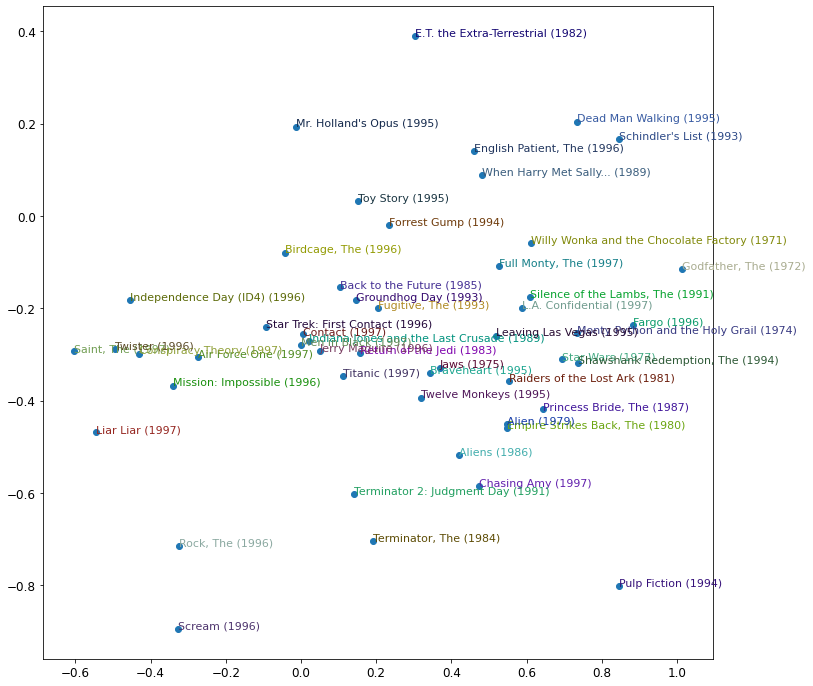

In [29]:
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

The model is roughly classifying some concept of *classic* and *pop culture*.

### Using fastai.collab

Fastai's `collab_learner` allows us to create and train a collaborative filtering model.

In [30]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [31]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.938278,0.954522,00:06
1,0.836250,0.872450,00:05
2,0.715342,0.832780,00:05
3,0.590198,0.817829,00:05
4,0.474934,0.818185,00:05


You can print the model to see the names of the layers.

In [32]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

Recreating previous analysis

In [33]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

### Embedding Distance

We can calculate the distance between embeddings to measure similarity (or lack of it) between movies. The metric is pythagorean distance. In this sense movies are similar if the users that like the movies are similar. The most similar movie to *Silence of the Lambs* is:

In [34]:
movie_factors = learn.model.i_weight.weight
# idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
# idx = dls.classes['title'].o2i['Forrest Gump (1994)']
idx = dls.classes['title'].o2i['Terminator, The (1984)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Alien (1979)'

## Bootstrapping a Collaborative Filtering Model

Great, so you have a trained model. Given a user with a reasonable watch history, you can make recommendations based on similar users' preferences.

Now, what do you do with a new user? They have no watch history to compare to other users. You could give a new user the mean of all the other users' embedding vectors. But the mean of the other users' vectors won't necessarily make sense. If half the users like horror, and half the users like action, your new user will be recommended half-horror half-action movies. 

Another option is to ask a set of questions, then assign an embedding vector based on the answers. This will give some control over the possible enbeddings.


The entire concept of collaborative filtering here is based on users' ratings. If there are users that rate a lot, they can tilt the system towards their preferences. They can create feedback loops, where their tastes are overrepresented. It's hard to quantify this overrepresentation though.


## Deep Learning for Collaborative Filtering

For deep learning, we can concatenate the results of the embedding lookup. The resulting matrix can be passed through linear layers and nonlinear layers as normal.

Instead of getting the dot product we will concatenate the embeddings. Because of this the matrices can have different sizes. Fastais `get_emb_sz` returns recommended sizes - aka numbers of latent factors. 

In [35]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

Let's implement this class:

In [36]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

And use it to create a model:

In [37]:
model = CollabNN(*embs)

The `Embedding` layers are created in `CollabNN`. `embs` infers the sizes. `self.layers` is our mini-Neural Net and in `forward` we apply the embeddings, concatenate results, and pass through the mini neural net. Then `sigmoid_range` is applied.

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.940104,0.959786,00:15
1,0.893943,0.905222,00:14
2,0.865591,0.875238,00:14
3,0.800177,0.867468,00:14
4,0.760255,0.867455,00:14


Within `fastai.collab`, if you use `collab_learner` and pass `use_nn=True` it will apply the neural network as part of the collaborative filtering model. The code below makes two hidden layers, of size 100 and 50 respectively:

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.002747,0.972392,00:16
1,0.926903,0.922348,00:16
2,0.877160,0.893401,00:16
3,0.838334,0.865040,00:16
4,0.781666,0.864936,00:16


## Conclusion

This application shows how we can learn the underlying factors within a dataset, and quanitfy aspects of the data. This can give us information that is otherwise unmeasured.